In [20]:
import os
import sys
sys.path.append("/mofem_install/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-9.4.0/tfel-4.0.0-jjcwdu6cbil5dzqzjhjekn3jdzo3e6gc/lib/python3.11/site-packages")
import numpy as np
import mtest
from pydantic import BaseModel

class StressTestLoadCase(BaseModel):
    SXX: dict[float, float] | None = None
    SYY: dict[float, float] | None = None
    SZZ: dict[float, float] | None = None
    
    def unpack(self):
        if self.SXX:
            m.setImposedStrain("SXX", self.SXX)
        if self.SYY:
            m.setImposedStrain("SYY", self.SYY)
        if self.SZZ:
            m.setImposedStrain("SZZ", self.SZZ)

class StrainTestLoadCase(BaseModel):
    EXX: dict[float, float] | None = None
    EYY: dict[float, float] | None = None
    EZZ: dict[float, float] | None = None
    
    def unpack(self):
        if self.EXX:
            m.setImposedStrain("EXX", self.EXX)
        if self.EYY:
            m.setImposedStrain("EYY", self.EYY)
        if self.EZZ:
            m.setImposedStrain("EZZ", self.EZZ)

m = mtest.MTest()
mtest.setVerboseMode(mtest.VerboseLevel.VERBOSE_QUIET)
m.setMaximumNumberOfSubSteps(20)
m.setModellingHypothesis("Tridimensional")

model = "DruckerPragerSimple"
# model = "DruckerPrager"
# model = "DruckerPragerCap"
# model = "DruckerPragerCapOriginal"
lib_path = "/mofem_install/jupyter/thomas/mfront_interface/src/libBehaviour.so"

b = mtest.Behaviour('generic', lib_path, model,'Tridimensional')
print(f"Material Properties: {b.getMaterialPropertiesNames()}")
print(f"State variables: {b.getInternalStateVariablesNames()}")
m.setBehaviour("generic", lib_path, model)
# in mfront:
# tan(beta) * p + q - R_DP_0 = 0
#R_DP_0 is named d in example
# FEA in geotech theory
# - M_JP * p' + J - M_JP * c' / tan(phi) = 0
# Souza
# n * p + sqrt(J2) - Xi * c = 0
# n is equal to M_JP
# Xi is M divided by tan(phi)
# q = sqrt(3J2)
# phi is the internal friction angle
E = 150
nu = 0.499
phi = np.radians(35)
v = np.radians(10)
c = 30
# fitting at triaxial compression: lode angle = -30
M_JP = 2 * np.sqrt(3) * np.sin(phi) / (3 -  np.sin(phi))

# Loading programme
tMax = 1.0  # s , total time
nTime = 2000
ltime = np.linspace(0.0, tMax, nTime)
# Environment parameters
m.setExternalStateVariable("Temperature", 293.15)
# Material parameters
m.setMaterialProperty("YoungModulus", E)
m.setMaterialProperty("PoissonRatio", nu)
if model == "DruckerPragerSimple":
    m.setMaterialProperty("phi", phi)
    m.setMaterialProperty("c", c)
elif model == "DruckerPrager":
    m.setMaterialProperty("phi", phi)
    m.setMaterialProperty("c", c)
    m.setMaterialProperty("v", v)
elif model == "DruckerPragerCap":
    beta = np.arctan(M_JP * np.sqrt(3))
    d = M_JP * c / np.tan(phi)
    m.setMaterialProperty("beta", beta)
    m.setMaterialProperty("d", d)
    m.setMaterialProperty("pa", 300)
    m.setMaterialProperty("pb", 500)
elif model == "DruckerPragerCapOriginal":
    m.setMaterialProperty("beta", beta)
    m.setMaterialProperty("d", d)
    m.setMaterialProperty("pa", -300)
    m.setMaterialProperty("pb", -500)
else:
    raise NotImplementedError()

controls = ["stress", "strain"]
control = controls[1]
if control == "stress":
    stlc1 = StressTestLoadCase(
        SXX = {0: 0, 1.0: 0},
        SYY = {0: 0, 1.0: 0},
        SZZ = {0: 0, 1.0: 130},
    )
    stlc2 = StressTestLoadCase(
        SXX = {0: 0, 1.0: 0},
        SYY = {0: 0, 1.0: 0},
        SZZ = {0: 0, 1.0: -60},
    )
    chosen = stlc1
    chosen.unpack()
if control == "strain":
    etlc1 = StrainTestLoadCase(
        EZZ = {0: 0, 0.25: 1.0, 0.5: 0.6, 0.75: 1.2, 1: 0.9},
    )
    chosen = etlc1
    chosen.unpack()

Material Properties: ['phi', 'c', 'YoungModulus', 'PoissonRatio']
State variables: ['ElasticStrain', 'EquivalentPlasticStrain', 'TrialEquivalentStress', 'PlasticStrain', 'test']


In [21]:
s = mtest.MTestCurrentState()
wk = mtest.MTestWorkSpace()
m.completeInitialisation()
m.initializeCurrentState(s)
m.initializeWorkSpace(wk)

# initialize output lists
sig_xx = []
sig_yy = []
sig_zz = []
sig_xy = []
sig_xz = []
sig_yz = []
e_xx = []
e_yy = []
e_zz = []
e_xy = []
e_xz = []
e_yz = []
e_e_xx = []
e_e_yy = []
e_e_zz = []
e_e_xy = []
e_e_xz = []
e_e_yz = []
extracting_pl = True
if extracting_pl:
    e_p_xx = []
    e_p_yy = []
    e_p_zz = []
    e_p_xy = []
    e_p_xz = []
    e_p_yz = []
e_p_eq = []
# run sim
for i in range(nTime - 1):
    # print(f"===========Loop {i}===========")
    if i == 0:
        sig_xx.append(s.s0[0])
        sig_yy.append(s.s0[1])
        sig_zz.append(s.s0[2])
        sig_xy.append(s.s0[3])
        sig_xz.append(s.s0[4])
        sig_yz.append(s.s0[5])
        e_xx.append(s.e0[0])
        e_yy.append(s.e0[1])
        e_zz.append(s.e0[2])
        e_xy.append(s.e0[3])
        e_xz.append(s.e0[4])
        e_yz.append(s.e0[5])
        eel = s.getInternalStateVariableValue("ElasticStrain")
        e_e_xx.append(eel[0])
        e_e_yy.append(eel[1])
        e_e_zz.append(eel[2])
        e_e_xy.append(eel[3])
        e_e_xz.append(eel[4])
        e_e_yz.append(eel[5])
        if extracting_pl:
            epl = s.getInternalStateVariableValue("PlasticStrain")
            e_p_xx.append(epl[0])
            e_p_yy.append(epl[1])
            e_p_zz.append(epl[2])
            e_p_xy.append(epl[3])
            e_p_xz.append(epl[4])
            e_p_yz.append(epl[5])
        epleq = s.getInternalStateVariableValue("EquivalentPlasticStrain")
        e_p_eq.append(epleq)

    try:
        m.execute(s, wk, ltime[i], ltime[i + 1])
    except Exception as e:
        break
    sig_xx.append(s.s1[0])
    sig_yy.append(s.s1[1])
    sig_zz.append(s.s1[2])
    sig_xy.append(s.s1[3])
    sig_xz.append(s.s1[4])
    sig_yz.append(s.s1[5])
    e_xx.append(s.e1[0])
    e_yy.append(s.e1[1])
    e_zz.append(s.e1[2])
    e_xy.append(s.e1[3])
    e_xz.append(s.e1[4])
    e_yz.append(s.e1[5])
    eel = s.getInternalStateVariableValue("ElasticStrain")
    e_e_xx.append(eel[0])
    e_e_yy.append(eel[1])
    e_e_zz.append(eel[2])
    e_e_xy.append(eel[3])
    e_e_xz.append(eel[4])
    e_e_yz.append(eel[5])
    if extracting_pl:
        epl = s.getInternalStateVariableValue("PlasticStrain")
        e_p_xx.append(epl[0])
        e_p_yy.append(epl[1])
        e_p_zz.append(epl[2])
        e_p_xy.append(epl[3])
        e_p_xz.append(epl[4])
        e_p_yz.append(epl[5])
    epleq = s.getInternalStateVariableValue("EquivalentPlasticStrain")
    e_p_eq.append(epleq)

sig_xx = np.array(sig_xx)   
sig_yy = np.array(sig_yy)   
sig_zz = np.array(sig_zz)   
sig_xy = np.array(sig_xy)   
sig_xz = np.array(sig_xz)   
sig_yz = np.array(sig_yz)
e_xx = np.array(e_xx)   
e_yy = np.array(e_yy)   
e_zz = np.array(e_zz)   
e_xy = np.array(e_xy)   
e_xz = np.array(e_xz)   
e_yz = np.array(e_yz) 
e_e_xx = np.array(e_e_xx)   
e_e_yy = np.array(e_e_yy)   
e_e_zz = np.array(e_e_zz)   
e_e_xy = np.array(e_e_xy)   
e_e_xz = np.array(e_e_xz)   
e_e_yz = np.array(e_e_yz)  
if extracting_pl:
    e_p_xx = np.array(e_p_xx)   
    e_p_yy = np.array(e_p_yy)   
    e_p_zz = np.array(e_p_zz)   
    e_p_xy = np.array(e_p_xy)   
    e_p_xz = np.array(e_p_xz)   
    e_p_yz = np.array(e_p_yz)  
e_p_eq = np.array(e_p_eq)  


In [22]:
# Function to calculate principal stresses and directions
def calculate_principal_stresses(sig_xx, sig_yy, sig_zz, sig_xy, sig_xz, sig_yz):
    sig_1 = []
    sig_2 = []
    sig_3 = []

    for i in range(len(sig_xx)):
        # Create stress tensor
        stress_tensor = np.array([
            [sig_xx[i], sig_xy[i], sig_xz[i]],
            [sig_xy[i], sig_yy[i], sig_yz[i]],
            [sig_xz[i], sig_yz[i], sig_zz[i]]
        ])

        # Calculate principal stresses (eigenvalues)
        principal_stresses, _ = np.linalg.eigh(stress_tensor)
        principal_stresses = np.sort(principal_stresses)[::-1]  # Sort in descending order

        # Append principal stresses to respective lists
        sig_1.append(principal_stresses[0])
        sig_2.append(principal_stresses[1])
        sig_3.append(principal_stresses[2])

    # Convert lists to numpy arrays
    sig_1 = np.array(sig_1)
    sig_2 = np.array(sig_2)
    sig_3 = np.array(sig_3)

    return sig_1, sig_2, sig_3

def calculate_p(sig_1, sig_2, sig_3):
    return (sig_1 + sig_2 + sig_3) / 3

# Function to calculate J2 invariant
def calculate_J2(sig_1, sig_2, sig_3):
    J2_list = (1/6) * ((sig_1 - sig_2) ** 2 + (sig_2 - sig_3) ** 2 + (sig_3 - sig_1) ** 2)
    
    return J2_list

# Function to calculate volumetric strain and deviatoric strain
def calculate_volumetric_and_deviatoric_strain(e_xx, e_yy, e_zz, e_xy, e_xz, e_yz):
    volumetric_strain_list = []
    deviatoric_strain_list = []

    for i in range(len(e_xx)):
        # Volumetric strain is the trace of the strain tensor
        volumetric_strain = e_xx[i] + e_yy[i] + e_zz[i]
        volumetric_strain_list.append(volumetric_strain)

        # Deviatoric strain components
        e_mean = volumetric_strain / 3
        e_dev_xx = e_xx[i] - e_mean
        e_dev_yy = e_yy[i] - e_mean
        e_dev_zz = e_zz[i] - e_mean
        e_dev_xy = e_xy[i]
        e_dev_xz = e_xz[i]
        e_dev_yz = e_yz[i]

        # Deviatoric strain magnitude
        deviatoric_strain = np.sqrt(2/3 * (e_dev_xx**2 + e_dev_yy**2 + e_dev_zz**2) + 2 * (e_dev_xy**2 + e_dev_xz**2 + e_dev_yz**2))
        deviatoric_strain_list.append(deviatoric_strain)

    volumetric_strain_list = np.array(volumetric_strain_list)
    deviatoric_strain_list = np.array(deviatoric_strain_list)
    return volumetric_strain_list, deviatoric_strain_list

sig_1, sig_2, sig_3 = calculate_principal_stresses(sig_xx, sig_yy, sig_zz, sig_xy, sig_xz, sig_yz)

p = calculate_p(sig_1, sig_2, sig_3)
J_2 = calculate_J2(sig_1, sig_2, sig_3)
J = np.sqrt(J_2)
tau_oct = np.sqrt(2 * J_2)
sig_eq = np.sqrt(3 * J_2)

# from properties
cone_radius = np.sqrt(2) *  (c / np.tan(phi) + p) * M_JP
cone_tip_p = - c / np.tan(phi)
e_v, e_d = calculate_volumetric_and_deviatoric_strain(e_xx, e_yy, e_zz, e_xy, e_xz, e_yz)
e_e_v, e_e_d = calculate_volumetric_and_deviatoric_strain(e_e_xx, e_e_yy, e_e_zz, e_e_xy, e_e_xz, e_e_yz)
if extracting_pl:
    e_p_v, e_p_d = calculate_volumetric_and_deviatoric_strain(e_p_xx, e_p_yy, e_p_zz, e_p_xy, e_p_xz, e_p_yz)

In [23]:
import matplotlib.pyplot as plt
import matplotlib

PLOT_DIR = f"/mofem_install/jupyter/thomas/mfront_interface/mtest_plots/{model}"
os.makedirs(PLOT_DIR, exist_ok=True)

matplotlib.rc('figure', figsize=(7, 7))


# Initialize axes for 3D plotting
def init_axes():
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    return fig, ax

def plot_cone_and_points(ax, radius, start_height=-50, end_height=100):
    # Step 1: Define the direction vector of the space diagonal
    diagonal_direction = np.array([1, 1, 1]) / np.linalg.norm([1, 1, 1])

    # Step 2: Generate the cone along the direction of the space diagonal
    height = np.linspace(0, end_height - start_height, 50)
    angle = np.linspace(0, 2 * np.pi, 100)
    Height, Angle = np.meshgrid(height, angle)

    # Define two orthogonal vectors that are perpendicular to the diagonal direction
    orthogonal_vector_1 = np.array([1.0, -1.0, 0.0])
    orthogonal_vector_1 /= np.linalg.norm(orthogonal_vector_1)
    orthogonal_vector_2 = np.cross(diagonal_direction, orthogonal_vector_1)

    # Compute the radius of the cone at each height (linearly increases from zero)
    cone_radius = radius * (Height / (end_height - start_height))
    # print(cone_radius[-1])
    # Compute the coordinates of the cone
    X = (cone_radius * np.cos(Angle) * orthogonal_vector_1[0] +
         cone_radius * np.sin(Angle) * orthogonal_vector_2[0] +
         (Height + start_height) * diagonal_direction[0])
    Y = (cone_radius * np.cos(Angle) * orthogonal_vector_1[1] +
         cone_radius * np.sin(Angle) * orthogonal_vector_2[1] +
         (Height + start_height) * diagonal_direction[1])
    Z = (cone_radius * np.cos(Angle) * orthogonal_vector_1[2] +
         cone_radius * np.sin(Angle) * orthogonal_vector_2[2] +
         (Height + start_height) * diagonal_direction[2])

    # Step 3: Plot the cone
    ax.plot_surface(X, Y, Z, alpha=0.5, color='m')

    # Step 4: Set the base of the cone for the circle at the end height
    base_point = end_height * diagonal_direction

    # Step 5: Plot a circle around the base point to indicate it lies on the cone plane
    circle_angle = np.linspace(0, 2 * np.pi, 100)
    cone_radius_at_base = radius
    circle_x = (cone_radius_at_base * np.cos(circle_angle) * orthogonal_vector_1[0] +
                cone_radius_at_base * np.sin(circle_angle) * orthogonal_vector_2[0] +
                base_point[0])
    circle_y = (cone_radius_at_base * np.cos(circle_angle) * orthogonal_vector_1[1] +
                cone_radius_at_base * np.sin(circle_angle) * orthogonal_vector_2[1] +
                base_point[1])
    circle_z = (cone_radius_at_base * np.cos(circle_angle) * orthogonal_vector_1[2] +
                cone_radius_at_base * np.sin(circle_angle) * orthogonal_vector_2[2] +
                base_point[2])
    ax.plot(circle_x, circle_y, circle_z, color='b')
    ax.scatter(*base_point, color='b', s=100)

    # Step 6: Define a plane that cuts through the cone at the base height
    plane_normal = diagonal_direction
    plane_point = base_point  # Plane passes through the base point

    # Step 7: Find intersection points of the plane with the cone
    cone_points = np.vstack((X.flatten(), Y.flatten(), Z.flatten())).T
    plane_distances = np.dot(cone_points - plane_point, plane_normal)
    intersection_indices = np.where(np.abs(plane_distances) < 0.05)[0]
    intersection_points = cone_points[intersection_indices]

    # Step 8: Pick three random points from the intersection points
    if intersection_points.shape[0] >= 3:
        random_indices = np.random.choice(intersection_points.shape[0], 3, replace=False)
        random_points = intersection_points[random_indices]
        # Plot the three random points and lines connecting them to the base point
        for i in range(3):
            ax.scatter(random_points[i, 0], random_points[i, 1], random_points[i, 2], color='g', s=50)
            ax.plot([base_point[0], random_points[i, 0]],
                    [base_point[1], random_points[i, 1]],
                    [base_point[2], random_points[i, 2]], color='k', linestyle='--')
            distance = np.linalg.norm(random_points[i] - base_point)
            print(f"Distance from base point to point {i+1}: {distance:.2f}")
    else:
        print("Not enough intersection points found to select three random points.")
        
# Plot stress history with classification based on tau_oct
def plot_stress_history(ax, sig_1, sig_2, sig_3, tau_oct, tau_oct_limit, save_as: str =None):
    
    mask_elastic = tau_oct < tau_oct_limit
    mask_plastic = tau_oct >= tau_oct_limit
    if np.any(mask_elastic):
        ax.plot(sig_1[mask_elastic], sig_2[mask_elastic], sig_3[mask_elastic], color='b', label='Elastic', linewidth=2)
    if np.any(mask_plastic):
        ax.plot(sig_1[mask_plastic], sig_2[mask_plastic], sig_3[mask_plastic], color='orange', label='Plastic', linewidth=2)

    vol_stress_value = (sig_1 + sig_2 + sig_3) / 3
    diagonal_direction = np.array([1, 1, 1]) / np.linalg.norm([1, 1, 1])
    vol_stress_x = vol_stress_value * diagonal_direction[0]
    vol_stress_y = vol_stress_value * diagonal_direction[1]
    vol_stress_z = vol_stress_value * diagonal_direction[2]
    ax.plot(vol_stress_x, vol_stress_y, vol_stress_z, color='r', linestyle='--', label='Volumetric Stress')
    ax.plot([vol_stress_x[-1], sig_1[-1]], [vol_stress_y[-1], sig_2[-1]], [vol_stress_z[-1], sig_3[-1]], color='g', linestyle='--', label='Deviatoric Stress')

# Plot metadata like labels and planes
def plot_meta(ax, elev, azim):
    ax.set_xlabel(r'$\sigma_1$')
    ax.set_ylabel(r'$\sigma_2$')
    ax.set_zlabel(r'$\sigma_3$')
    ax.set_title('3D Plot of Principal Stresses')

    # Plot planes and add arrowheads with labels
    ylim = ax.get_ylim()
    xlim = ax.get_xlim()
    zlim = ax.get_zlim()
    text_fontsize = 10
    # y-plane
    ax.plot([0, 0], ylim, [0, 0], color='k', linestyle='--', alpha=0.5)
    ax.text(0, ylim[1] + text_fontsize * 2.5, 0, r'$\sigma_2$', color='k', fontsize=text_fontsize, verticalalignment='center_baseline', horizontalalignment='center')

    # x-plane
    ax.plot(xlim, [0, 0], [0, 0], color='k', linestyle='--', alpha=0.5)
    ax.text(xlim[1] + text_fontsize * 2.5, 0, 0, r'$\sigma_1$', color='k', fontsize=text_fontsize, verticalalignment='center_baseline', horizontalalignment='center')

    # z-plane
    ax.plot([0, 0], [0, 0], zlim, color='k', linestyle='--', alpha=0.5)
    ax.text(0, 0, zlim[1] + text_fontsize * 2.5, r'$\sigma_3$', color='k', fontsize=text_fontsize, verticalalignment='center_baseline', horizontalalignment='center')

    limits = np.array([getattr(ax, f'get_{axis}lim')() for axis in 'xyz'])
    ax.set_box_aspect(np.ptp(limits, axis=1))
    ax.view_init(elev=elev, azim=azim)
    ax.legend()

    ax.set_axis_off()
    plt.tight_layout()


# Plot functions for specific variables
def plot_stress_field(sig_1, sig_2, sig_3, tau_oct, cone_radius, cone_tip_p, final_p, elev, azim, save_as: str =None):
    fig, ax = init_axes()
    plot_cone_and_points(ax, radius=cone_radius[-1], start_height = cone_tip_p, end_height=final_p)
    plot_stress_history(ax, sig_1, sig_2, sig_3, tau_oct, cone_radius)
    plot_meta(ax, elev, azim)
    
    if save_as:
        filepath = os.path.join(PLOT_DIR, save_as)
        plt.savefig(filepath)
        return filepath


In [24]:
def plot_2d_with_quiver(x, y, xlabel, ylabel, title, color='b', scale=1, linestyle='-', label=None, plastic_cutoff=None, save_as: str = None):
    plt.figure()
    tolerance = 1e-6
    gradient_tolerance = 0.01
    gradients = np.gradient(y)
    print(y)
    start_idx = 0
    for i in range(len(y)-1):
        if not np.isclose(gradients[i], gradients[i + 1], atol=gradient_tolerance):
            dx = (x[i] - x[start_idx]) * 0.33
            dy = (y[i] - y[start_idx]) * 0.33
            current_color = 'orange' if np.isclose(y[i], plastic_cutoff[i], atol=tolerance) else 'b'
            if i - start_idx > 1:
                plt.quiver(x[start_idx], y[start_idx], dx, dy, color=current_color, scale=scale, angles='xy', scale_units='xy', headwidth=5, headlength=4.5,zorder=10)
            start_idx = i

    dx = (x[-1] - x[start_idx]) * 0.33
    dy = (y[-1] - y[start_idx]) * 0.33
    current_color = 'orange' if np.isclose(y[start_idx], plastic_cutoff[start_idx], atol=tolerance) else 'b'
    if i - start_idx > 1:
        plt.quiver(x[start_idx], y[start_idx], dx, dy, color=current_color, scale=scale, angles='xy', scale_units='xy', headwidth=5, headlength=4.5,zorder=10)

    plot_color = []
    start_idx = 0
    for i in range(len(y)-1):
        current_color = 'orange' if (plastic_cutoff is not None and np.isclose(plastic_cutoff[i], y[i], atol=tolerance)) else color
        if i == 0 or plot_color[-1] != current_color:
            if i > 0:
                plt.scatter(x[start_idx:i], y[start_idx:i], color=plot_color[-1], s=0.5)
            start_idx = i
            plot_color.append(current_color)

    plt.scatter(x[start_idx:], y[start_idx:], color=current_color, s=0.5)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True,zorder=0)
    
    if save_as:
        filepath = os.path.join(PLOT_DIR, save_as)
        plt.savefig(f"{filepath}.png")
        return save_as
    plt.show()

def create_plot(data, x_label, y_label, title, save_as):
    linestyle = "-"
    fig, ax = plt.subplots()
    max_x, max_y = float('-inf'), float('-inf')
    for x, y, label, color, cutoff in data:
        if x is not None and y is not None:
            if cutoff:
                mask_elastic = abs(y) < abs(cutoff)
                mask_plastic = abs(y) >= abs(cutoff)
                plt.plot(x[mask_elastic], y[mask_elastic], linestyle=linestyle, color='b', label=f"label")
                plt.plot(x[mask_plastic], y[mask_plastic], linestyle=linestyle, color='orange', label=label)
            else:
                plt.plot(x, y, linestyle=linestyle, color=color, label=label)
            max_x = max(max_x, max(x))
            max_y = max(max_y, max(y))
    
    # Add axis labels and title
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.legend()

    ax.grid(True)

    # # Center the spines
    # ax.spines['left'].set_position(('data', 0))
    # ax.spines['bottom'].set_position(('data', 0))
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)

    # # Draw arrows at the maximum x and y values
    # ax.plot(max_x, 0, ">k", transform=ax.get_yaxis_transform(), clip_on=False)  # Arrow for X-axis
    # ax.plot(0, max_y, "^k", transform=ax.get_xaxis_transform(), clip_on=False)  # Arrow for Y-axis

    # Adjust limits to make sure arrows are visible
    # x_min, x_max = ax.get_xlim()
    # y_min, y_max = ax.get_ylim()
    # ax.set_xlim(min(x_min, -0.1), max(x_max, 1.1))
    # ax.set_ylim(min(y_min, -0.1), max(y_max, 1.1))

    if save_as:
        filepath = os.path.join(PLOT_DIR, save_as)
        plt.savefig(filepath)
        return filepath
    
def plot_J_vs_axial_strain(J, e_zz, save_as: str =None):
    return plot_2d_with_quiver(e_zz, J, 'Axial Strain $\epsilon_{zz}$', 'Deviatoric Stress J', 'J - Axial Strain', plastic_cutoff= (c / np.tan(phi) + p[-1]) * M_JP, save_as=save_as)

def plot_tau_vs_e_zz(tau_oct, e_zz, save_as: str =None):
    return plot_2d_with_quiver(e_zz, tau_oct, 'Axial Strain $\epsilon_{zz}$', 'Octahedral Shear Stress $\\tau_{oct}$', '$\\tau_{oct}$ - Axial Strain', plastic_cutoff= np.sqrt(2) *  (c / np.tan(phi) + p[-1]) * M_JP, save_as=save_as)

def plot_sig_eq_vs_e_zz(sig_eq, e_zz, save_as: str =None):
    return plot_2d_with_quiver(e_zz, sig_eq, 'Axial Strain $\epsilon_{zz}$', 'Equivalent Stress $\sigma_{eq}$', '$\sigma_{eq}$ - Axial Strain', plastic_cutoff= np.sqrt(3) *  (c / np.tan(phi) + p
                                                                                                                                                                               ) * M_JP,save_as=save_as)

def plot_volumetric_strain_vs_axial_strain(e_zz, e_v=None, e_e_v=None, e_p_v=None, save_as: str = None):
    data = [
        (e_zz, e_v, 'Total $\epsilon^{tot}_v$', 'g', None),
        (e_zz, e_e_v, 'Elastic $\epsilon^e_v$', 'b', None),
        (e_zz, e_p_v, 'Plastic $\epsilon^p_v$', 'r', None),
    ]
    return create_plot(data, 'Axial Strain $\epsilon_{zz}$', 'Volumetric Strain $\epsilon_v$', 'Volumetric Strain vs Axial Strain', save_as)

def plot_deviatoric_strain_vs_axial_strain(e_zz, e_d=None, e_e_d=None, e_p_d=None, save_as: str = None):
    data = [
        (e_zz, e_d, 'Total $\epsilon^{tot}_d$', 'g', None),
        (e_zz, e_e_d, 'Elastic $\epsilon^e_d$', 'b', None),
        (e_zz, e_p_d, 'Plastic $\epsilon^p_d$', 'r', None),
    ]
    return create_plot(data, 'Axial Strain $\epsilon_{zz}$', 'Deviatoric Strain $\epsilon_d$', 'Deviatoric Strain vs Axial Strain', save_as)

def plot_volumetric_strain_vs_deviatoric_strain(e_v, e_d, e_e_d=None, e_e_v=None, e_p_d=None, e_p_v=None, save_as: str = None):
    data = [
        (e_d, e_v, 'Total Strain', 'g', None),
        (e_e_d, e_e_v, 'Elastic Strain', 'b', None),
        (e_p_d, e_p_v, 'Plastic Strain', 'r', None),
    ]
    return create_plot(data, 'Deviatoric Strain $\epsilon_d$', 'Volumetric Strain $\epsilon_v$', 'Volumetric Strain vs Deviatoric Strain', save_as)

def plot_e_p_eq_vs_e_zz(e_p_eq, e_zz, e_p_eq_calc=None, ok=False, save_as: str = None):
    data = [
        (e_zz, e_p_eq, 'Equivalent Plastic Strain', 'g', None),
        # (e_zz, e_p_eq_calc if ok and e_p_eq_calc is not None else None, 'Calculated Plastic Strain', 'b', None),
    ]
    return create_plot(data, 'Axial Strain $\epsilon_{zz}$', 'Equivalent Plastic Strain $e^p_{eq}$', 'Equivalent Plastic Strain vs Axial Strain', save_as)

def plot_e_xx_vs_e_zz(e_xx, e_zz, save_as: str = None):
    data = [
        (e_zz, e_xx, 'Lateral Strain $\epsilon_{xx}=\epsilon_{yy}$', 'g', None),
    ]
    return create_plot(data, 'Axial Strain $\epsilon_{zz}$', 'Lateral Strain $\epsilon_{xx}=\epsilon_{yy}$', '$\epsilon_{xx}=\epsilon_{yy}$ - Axial Strain', save_as=save_as)

Distance from base point to point 1: 76.76
Distance from base point to point 2: 76.76
Distance from base point to point 3: 76.76
Distance from base point to point 1: 76.76
Distance from base point to point 2: 76.76
Distance from base point to point 3: 76.76
Distance from base point to point 1: 76.76
Distance from base point to point 2: 76.76
Distance from base point to point 3: 76.76
[ 0.          0.30015008  0.60030015 ... 70.48404017 70.39399515
 70.30395013]


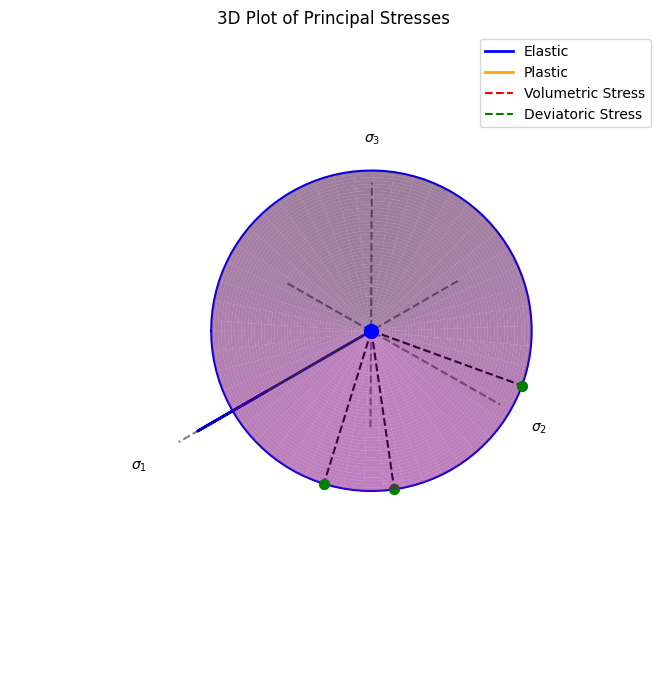

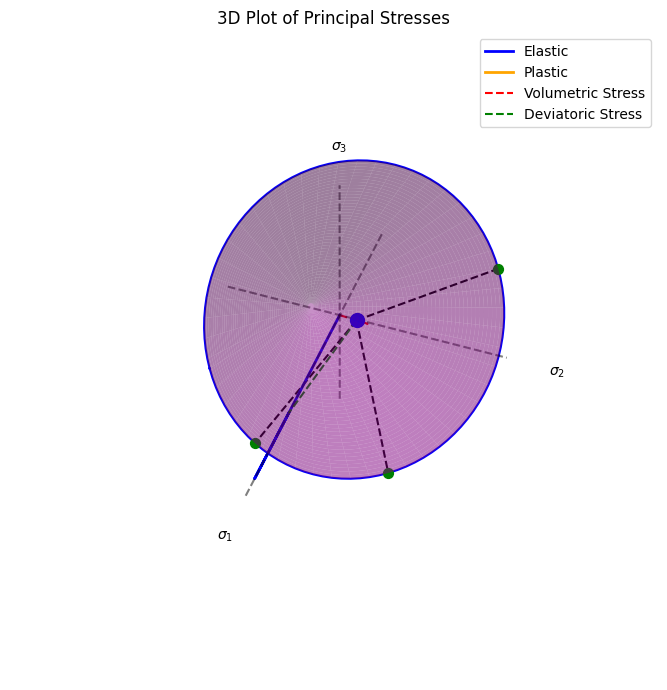

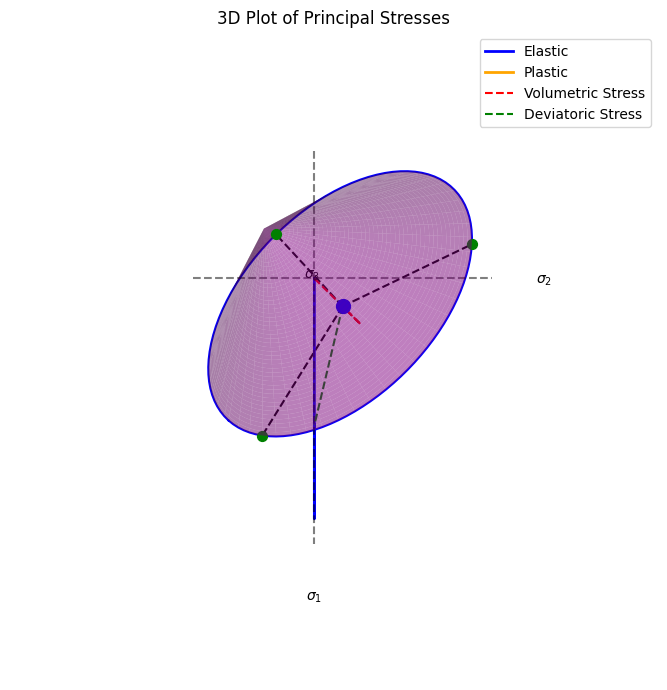

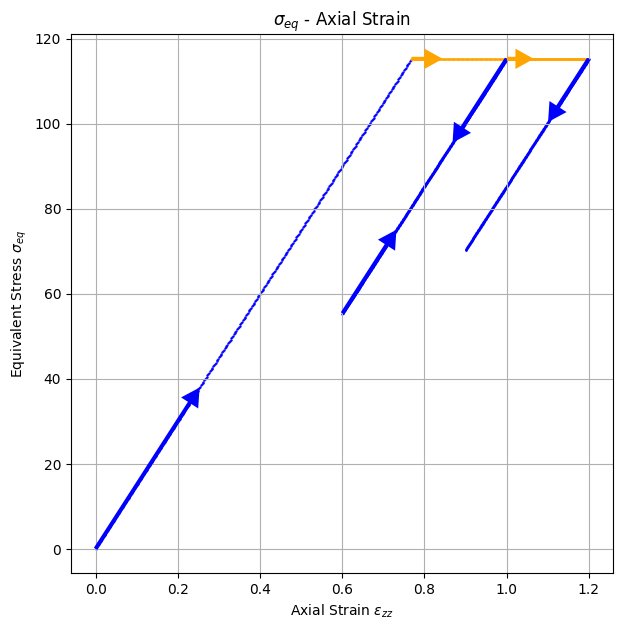

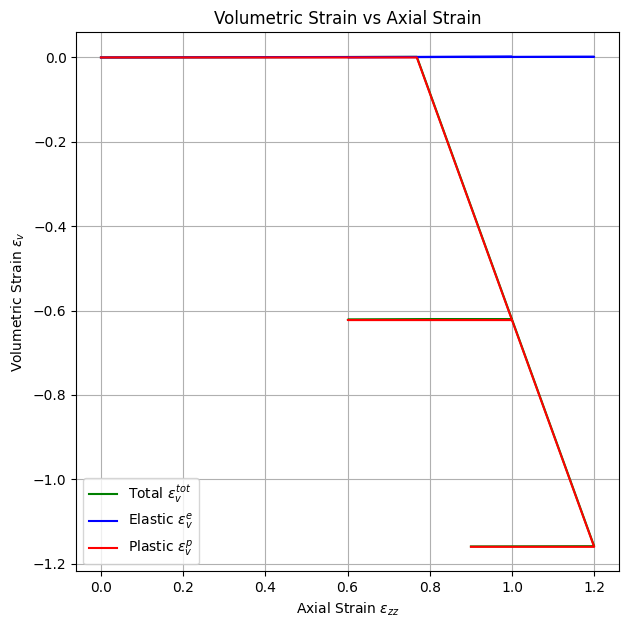

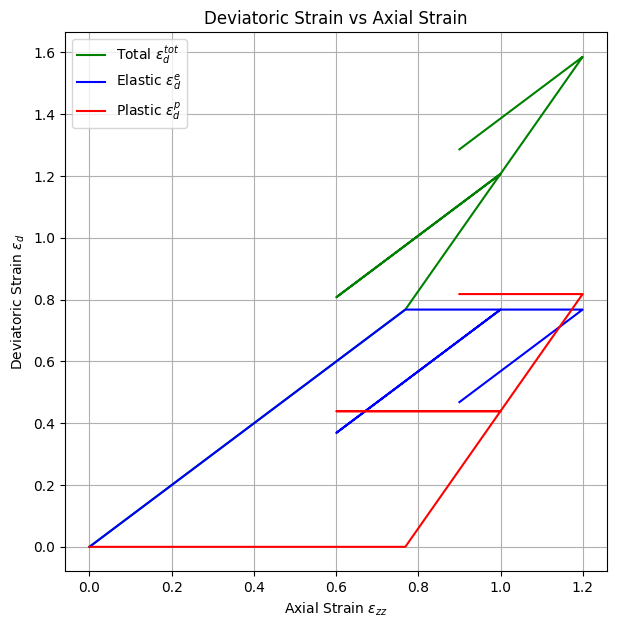

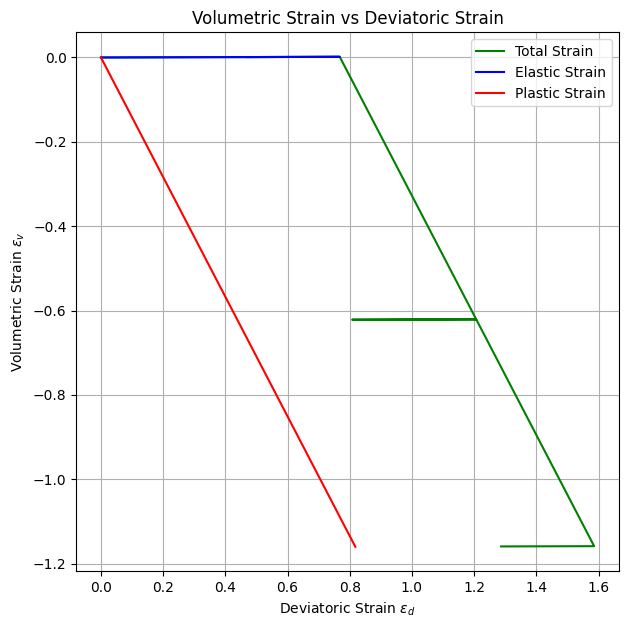

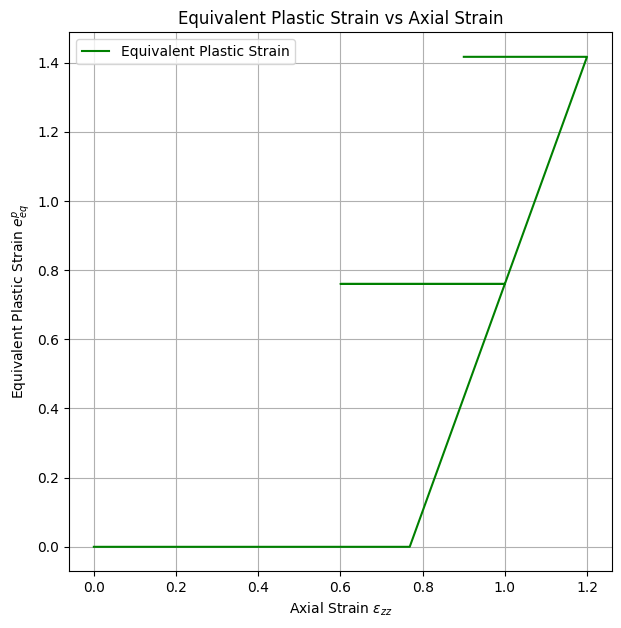

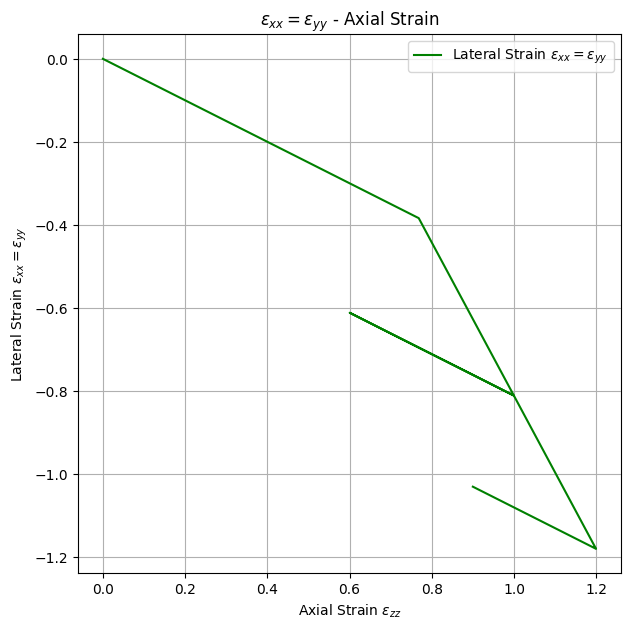

In [25]:
image_files = []
image_files.append(plot_stress_field(sig_1, sig_2, sig_3, tau_oct, cone_radius, cone_tip_p = cone_tip_p, final_p = p[-1],elev=np.degrees(np.arccos(np.sqrt(2/3))),azim=45,save_as="1_stress_field.png"))
image_files.append(plot_stress_field(sig_1, sig_2, sig_3, tau_oct, cone_radius, cone_tip_p = cone_tip_p, final_p = p[-1],elev=45,azim=20,save_as="1_stress_field_alt2.png"))
image_files.append(plot_stress_field(sig_1, sig_2, sig_3, tau_oct, cone_radius, cone_tip_p = cone_tip_p, final_p = p[-1],elev=90,azim=0,save_as="1_stress_field_alt3.png"))
# image_files.append(plot_J_vs_axial_strain(J, e_zz,save_as="2_J_ezz"))
# image_files.append(plot_tau_vs_e_zz(tau_oct, e_zz,save_as="3_tau_ezz"))
image_files.append(plot_sig_eq_vs_e_zz(sig_eq, e_zz,save_as="4_sigeq_ezz"))
image_files.append(plot_volumetric_strain_vs_axial_strain(e_zz=e_zz, e_v=e_v, e_e_v=e_e_v, e_p_v=e_p_v,save_as="5_ev_ezz.png"))
image_files.append(plot_deviatoric_strain_vs_axial_strain(e_zz=e_zz, e_d=e_d, e_e_d=e_e_d, e_p_d=e_p_d,save_as="6_ed_ezz.png"))
image_files.append(plot_volumetric_strain_vs_deviatoric_strain(e_v=e_v, e_d=e_d, e_e_v=e_e_v, e_e_d=e_e_d, e_p_v=e_p_v, e_p_d=e_p_d,save_as="7_ev_ed.png"))
image_files.append(plot_e_p_eq_vs_e_zz(e_p_eq, e_zz,save_as="8_epeq_ezz.png"))
image_files.append(plot_e_xx_vs_e_zz(e_xx, e_zz,save_as="9_exx_ezz.png"))

In [26]:
# from IPython.display import display, HTML

# # Time-related images with a common title
# display(HTML('<h3 style="text-align:left">DRUCKER-PRAGER</h3>'))


# images_html = ''.join([
#     f'<img src="{img}" style="display:inline;margin:1px" width="500"/>'
#     for img in image_files
# ])
# display(HTML(images_html))
